# PhaseAutoEncoder for GENEA 2023 challenge
Here we are trying to adapt PhaseAutoEncoder (PAE) from Sebastian Starke (https://github.com/sebastianstarke/AI4Animation) to conversational gesture generation in GENEA 2023 Challange (https://genea-workshop.github.io/2023/challenge/)

## Data preparation
First, we need to represent our data to fit PAE. For this we are trying to parse example dataset from original repo.

In [5]:
import numpy as np
from pathlib import Path
import array
import matplotlib.pyplot as plt

### Parsing PAE input data
Here we explore input data from DeepPhase tutorial. For that folow step-by-step on `Network.py` script.

In [16]:
dataset_folder = Path("./data/PAE_Dataset/")
datashape_path = dataset_folder / "DataShape.txt"
data_path = dataset_folder / "Data.bin"
sequences_path = dataset_folder / "Sequences.txt"

In [17]:
datashape = np.loadtxt(datashape_path, dtype=np.int64)
sample_count, feature_dim = datashape
print(sample_count, feature_dim)

342248 78


In [18]:
def read_binary(binary_file, sample_count, feature_dim, verbose_step: int = 1000):
    bytes_perline = feature_dim*4
    data = []
    with open(binary_file, "rb") as f:
        for i in np.arange(sample_count):
            if i % max(int(sample_count / verbose_step), 1) == 0:
                print('Reading binary ' + str(binary_file) + '...', round(100 * i / sample_count, 2), "%", end="\r")
            f.seek(i*bytes_perline)
            line_bytes = f.read(bytes_perline)
            buffer = array.array('f', line_bytes)
            data.append(np.float32(buffer))
    print('Reading binary ' + str(binary_file) + '...', 100, "%", end="\r")
    print("")
    return np.concatenate(data).reshape(sample_count, -1)

data = read_binary(data_path, sample_count, feature_dim)
data.shape

Reading binary data/PAE_Dataset/Data.bin... 100 % %


(342248, 78)

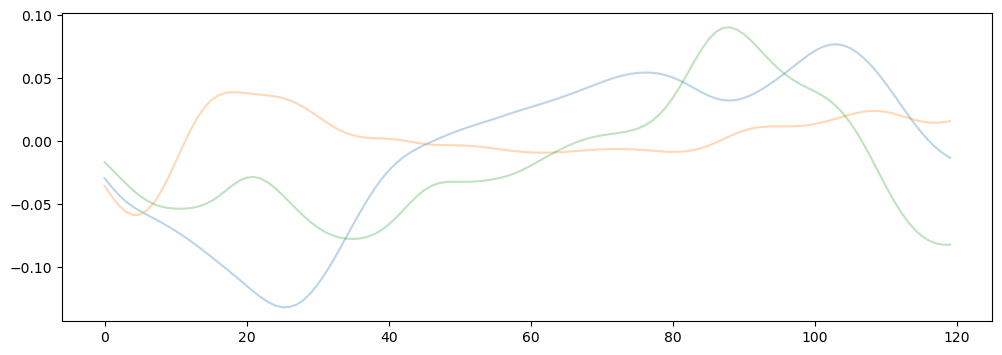

In [24]:
# plot some values
byaxes = data.reshape(342248, 26,3)
plt.figure(figsize=(12,4))
plt.plot(byaxes[:60*2,5,0], alpha=0.3)
plt.plot(byaxes[:60*2,5,1],alpha=0.3)
plt.plot(byaxes[:60*2,5,2], alpha=0.3)

Text(0.5, 1.0, 'by Z')

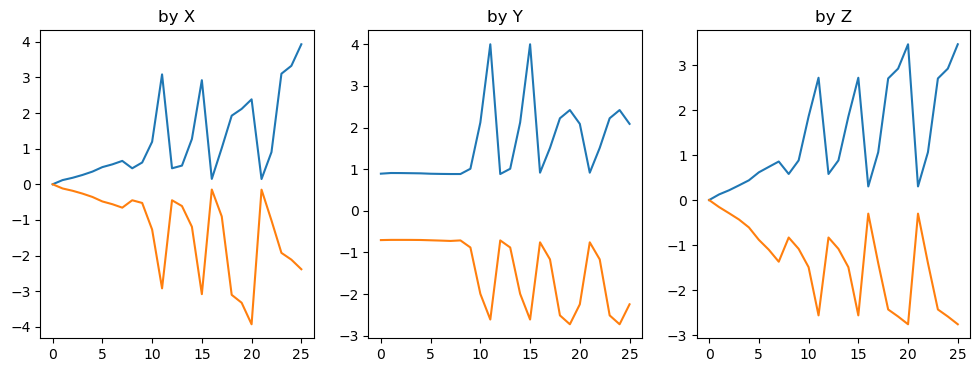

In [70]:
# also interesting min and max by axes and joints
maxes = byaxes.max(axis=0)
mins = byaxes.min(axis=0)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(maxes[:,0])
ax1.plot(mins[:,0])
ax1.set_title('by X')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(maxes[:,1])
ax2.plot(mins[:,1])
ax2.set_title('by Y')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(maxes[:,2])
ax3.plot(mins[:,2])
ax3.set_title('by Z')

In [25]:
def load_sequences(sequences_path, line_count):
    print("Loading" + str(sequences_path))
    data = []
    with open(sequences_path) as f:        
        for pivot, line in enumerate(f):
            entry = line.rstrip().split(' ')
            data.append(entry[0])
            if pivot == line_count:
                break
    return np.array(data, dtype=np.int64)

sequences = load_sequences(sequences_path, sample_count)

Loadingdata/PAE_Dataset/Sequences.txt


In [26]:
data_sequences = [] 
for i in range(sequences[-1]):
    indices = np.where(sequences == (i+1))[0]
    for j in range(indices.shape[0]):
        section = [indices[j], indices[0], indices[-1]]
        data_sequences.append(section) 
        
data_sequences = np.array(data_sequences)
# check if shape of binary data corresponds to sequence metadata
sample_count == len(data_sequences)

True

In [27]:
# now let's look how batch looks like
I = np.arange(sample_count)
train_indices = I[0:32]
train_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

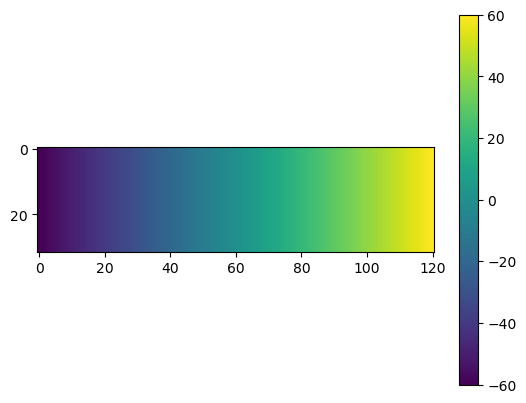

In [47]:
# now let's see how gather window looks like
window = 2.0
fps = 60
frames = int(window * fps) + 1
gather_padding = (int((frames-1)/2))
gather_window = np.arange(frames) - gather_padding
gather = gather_window.reshape(1,-1).repeat(train_indices.shape[0], 0)
plt.imshow(gather)
plt.colorbar()

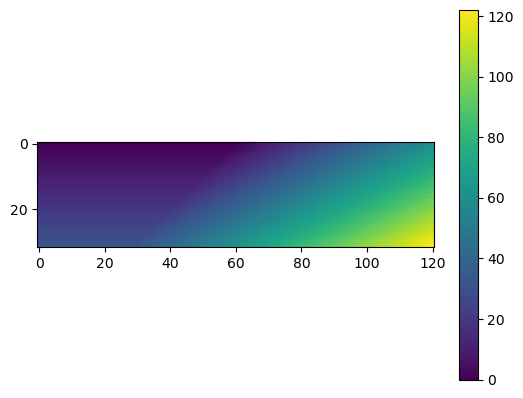

In [49]:
batch_sequences = data_sequences[train_indices]
pivots = batch_sequences[:,0].reshape(-1,1)
mins = batch_sequences[:,1].reshape(-1,1)
maxs = batch_sequences[:,2].reshape(-1,1)
gather = np.clip(gather + pivots, mins, maxs)
plt.imshow(gather)
plt.colorbar()

In [44]:
batch = data[gather.flatten()]
batch.shape
# this tensort goes to NN

(3872, 78)

In [46]:
# and reshaping like that
reshaped_batch = batch.reshape(gather.shape[0], gather.shape[1], -1)
reshaped_batch.shape

(32, 121, 78)

So, we've gotten what input data looks like. But it's also important what exactly this data is.
From C# code it looks like that input data is joints positions velosities. Joint positions were also transformed to charracter root and Butterworth filter was applied to each dimension. So, let's try the same on GENEA dataset.

### Exctract Positions from GENEA sample
First, let's extract positions from bvh use sclearn pipeline:
```
process_motion.py --mode pipeline --pipeline position --src ./data/trn/bvh --pipeline_dir ./pipe
```
```
process_motion.py --mode bvh2npy --src ./data/trn/bvh --dst ./data/trn/position
```

In [3]:
sample_data = np.load('data/position/val_2023_v0_000_main-agent.npy')
sample_data.shape

(1830, 78)

(0.0, 400.0)

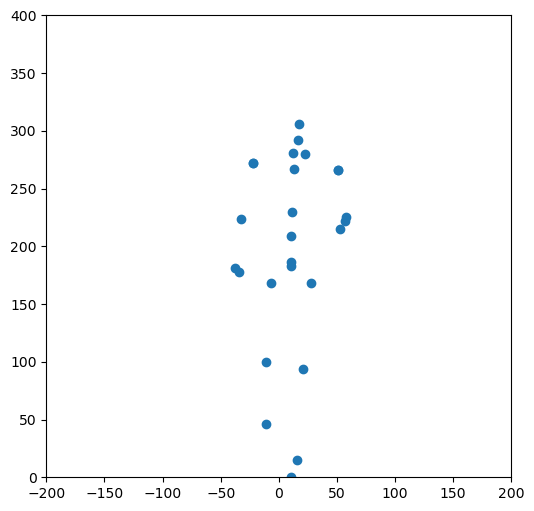

In [6]:
# draw some frame to make shure that extraction works
frame = sample_data[344]
frame_xyz = frame.reshape(-1, 3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(frame_xyz[:,0], frame_xyz[:,1],)
ax.set_xlim([-200, 200])
ax.set_ylim([0,400])

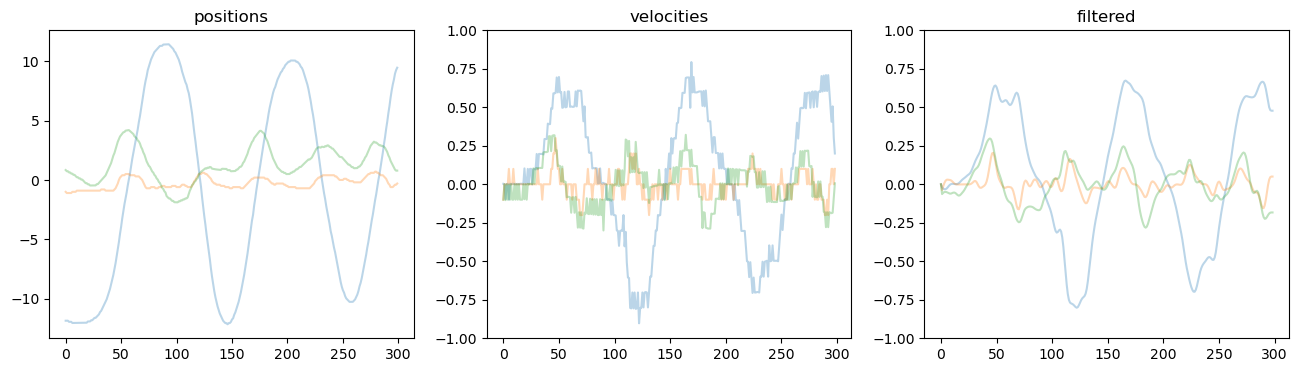

In [15]:
from src.utils.plotting import pos_vel_butter
# than draw posions of some joint along with velocities and Butterworth filter
pos_vel_butter(sample_data, 0)

Now we want to extract volocities, apply Butterworth filter and reconstruct data back.